In [1]:
import torch

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from time import sleep
from tqdm import trange
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch.utils.data import random_split
from sklearn.metrics import auc, roc_curve, f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class GCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels,hidden_channels)
        self.conv2 = GCNConv(hidden_channels,out_channels)
        self.fc = nn.Linear(out_channels,num_classes)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        #x = self.conv2(x, edge_index)
        #x = F.relu(x)
        x = F.dropout(x, training = self.training)
        x = self.fc(x)
        
        return F.log_softmax(x, dim=1)

In [3]:
class SAGEGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_classes):
        super(SAGEGCN, self).__init__()
        self.conv1 = SAGEConv(in_channels,hidden_channels)
        self.conv2 = SAGEConv(hidden_channels,out_channels)
        self.fc = nn.Linear(out_channels,num_classes)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        #x = self.conv2(x, edge_index)
        #x = F.relu(x)
        x = F.dropout(x, training = self.training)
        x = self.fc(x)
        
        return F.log_softmax(x, dim=1)

In [4]:
class Geo_GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_classes):
        super(Geo_GAT, self).__init__()
        self.conv1 = GATConv(in_channels,hidden_channels)
        self.conv2 = GATConv(hidden_channels,out_channels)
        self.fc = nn.Linear(out_channels,num_classes)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        #x = self.conv2(x, edge_index)
        #x = F.relu(x)
        x = F.dropout(x, training = self.training)
        x = self.fc(x)
        
        return F.log_softmax(x, dim=1)

In [5]:
### DATASET WITH JET FEATURES ONLY!!!! TRAINING WORKS :)
#train_data = torch.load('data/ttbar100k/processed/data_train.pt')
#test_data = torch.load('data/ttbar100k/processed/data_test.pt')

### DATASET WITH JET AND TRACK FEATURES
train_data = torch.load('data/wtracks/ttbar/processed/data_train.pt')
test_data = torch.load('data/wtracks/ttbar/processed/data_test.pt')

In [6]:
labels = torch.unique(train_data.y)
num_classes = labels.size(0)

# Pick the model from below

model = GCNModel(train_data.num_features, 16, 16, num_classes)
# model = SAGEGCN(train_data.num_features, 16, 16, num_classes)
# model = Geo_GAT(train_data.num_features, 16, 16, num_classes)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


In [7]:
def train():  
    total_train = train_data.num_nodes
    true_train_labels = train_data.y
    
    
    model.train()
    
    pbar = trange(400, desc="GCN training", unit="epoch")
    
    for i in pbar:
        sleep(0.1)
        pbar.set_description(f"Epoch {i}")
    
        optimizer.zero_grad()
        out = model(train_data)
        
        out = model(train_data)
        pred = out.max(dim=1)[1]
        
        correct = pred.eq(true_train_labels).sum().item()
        accuracy = correct/total_train
        
        loss = F.cross_entropy(out, true_train_labels)
        loss.backward()
        optimizer.step()
    
        pbar.set_postfix(loss=loss.item(), accuracy=100. * accuracy)
        sleep(0.1)
    

In [8]:
def get_metrics(plt_title, confusion_matrix_path):
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        # Get true label and prediction
        true = test_data.y
        out = model(test_data)
        pred = out.max(dim=1)[1]
        
        correct = pred.eq(true).sum().item()
        total = test_data.num_nodes
        
        true_y = true.numpy()
        pred_y = pred.numpy()
        
        F1 = f1_score(true_y, pred_y, average="weighted")
        
        print(f'Test Acc.: {correct/total:.4f}')
        print("F1 Score: ", F1)
        
        cm = confusion_matrix(true_y, pred_y)
        #cm = confusion_matrix(true_y, pred_y,normalize='true')

        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.title(plt_title)
        #plt.savefig(confusion_matrix_path)
        plt.show()
        
        print("Number of Nodes: ", len(pred_y))

In [9]:
def get_roc(plt_title, roc_path):
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
            true_y = test_data.y.numpy()
            out = model(test_data)            
            
            # The following converts log_softmax outputs into probablities
            probs = torch.exp(out).numpy()

    
            preds = []

            for i,p in enumerate(probs):
                preds.append(p[1]) # Get the probability of true class
            pred_y = np.array(preds)



            fpr_keras, tpr_keras, thresholds = roc_curve(true_y, pred_y)
            AUC = auc(fpr_keras, tpr_keras)
            plt.plot(fpr_keras, tpr_keras)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill')
            plt.title(plt_title)
            plt.xlabel("FPR")
            plt.ylabel("TPR")
            plt.text(0.75,0.1,"AUC:"+str(round(AUC,6)))
            #plt.savefig(roc_path)
            plt.show()

In [10]:
train()

Epoch 399: 100%|██████████| 400/400 [27:16<00:00,  4.09s/epoch, accuracy=55, loss=0.688]


Test Acc.: 0.5499
F1 Score:  0.39017852562981


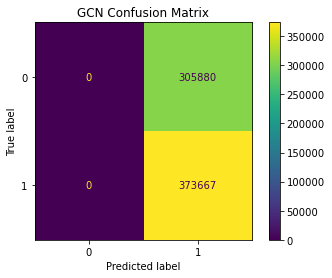

Number of Nodes:  679547


In [11]:
get_metrics('GCN Confusion Matrix','Datasets/ttbar/GAT_ConfusionMatrix.png') # plot title and filepath

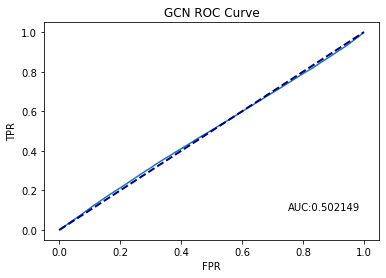

In [12]:
get_roc('GCN ROC Curve','Datasets/ttbar/GAT_roc.png') # Plot title and filepath